In [ ]:
######################################################
### 2019 - 2020 Maritime Trade with COVID for LSTM ###
######################################################

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Data_MaritimeTrade/

/content/drive/MyDrive/Data_MaritimeTrade


In [ ]:
!pip install Tensorflow==2.5.0
!pip install category_encoders
import os
import random
import pandas as pd
import numpy as np
import category_encoders as ce
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
%tensorflow_version 2.5.0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,  Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from math import sqrt
from numpy import concatenate
import matplotlib as plt
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

     |████████████████████████████████| 454.3 MB 16 kB/s 
     |████████████████████████████████| 1.2 MB 64.2 MB/s 
     |████████████████████████████████| 4.0 MB 68.0 MB/s 
     |████████████████████████████████| 462 kB 47.7 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.39.0
    Uninstalling grpcio-1.39.0:
      Successfully uninstalled grpcio-1.39.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: Tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalling tensorflow-2.6.0:
      Successfully uninstalled tensorflow-2.6.0
     |████████████████████████████████| 80 kB 5.6 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.5.0`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
TensorFlow version: 2.5.0
Eager execution is: True
Keras version: 2.5.0
Num GPUs Available:  0


In [ ]:
# Reproducibility in TF and Pytorch 
def init_seeds(seed=2019):
    np.random.seed(seed)
    random.seed(seed)
    session_conf = tf.compat.v1.ConfigProto()
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
    os.environ['TF_CUDNN_DETERMINISTIC'] ='true'
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    tf.random.set_seed(seed)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    return sess

In [ ]:
init_seeds(seed=2019)


In [ ]:
df = pd.read_csv('combined_trade_final_LSTM.csv',low_memory=False)
print('Number of rows and columns:', df.shape)

Number of rows and columns: (6633785, 20)


In [ ]:
def data_quality_table(df):
        mis_val = df.isnull().sum()
        #mis_val = df.isnull().sum().loc[lambda x : x>0] 
        #mis_val = df.loc[:, df.isna().any()].isna().sum()
        var_type = df.dtypes
        unique_count = df.nunique()
        mis_val_table = pd.concat([mis_val, var_type, unique_count], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Number Missing', 1 : 'Data Type', 2 : 'Number Unique'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        'Number Missing', ascending=False).round(1)
        print ("The selected dataframe has " + str(df.shape[1]) + " columns.\n")
        return mis_val_table_ren_columns

pd.set_option('display.max_columns', None)
print("\nData Quality Report") 
print(data_quality_table(df))


Data Quality Report
The selected dataframe has 20 columns.

                        Number Missing Data Type  Number Unique
Container_LCL/FCL                    0    object              2
Metric_Tons                          0   float64          24994
deaths_pctdelta                      0   float64           1034
cases_pctdelta                       0   float64           1103
State_Closure_EA_Diff                0     int64              7
deaths_weekly                        0   float64           1034
cases_weekly                         0   float64           1104
Average_Tariff                       0   float64            631
US_Unemployment_Rate                 0   float64             14
HS_Group_Name                        0    object              6
Foreign_Country_Region               0    object             11
US_Port_Coastal_Region               0    object              6
foreign_company_size                 0    object              6
us_company_size                      0    o

In [ ]:
# Convert dtypes
df = df.copy()
df['State_Closure_EA_Diff'] = df['State_Closure_EA_Diff'].astype('float64')
df['Container_Type_Dry'] = df['Container_Type_Dry'].astype('object')

In [ ]:
# Convert 
df = df.copy()
df['DateTime']= pd.to_datetime(df['DateTime']) 
df['DateTime_YearWeek'] = df['DateTime'].dt.strftime('%Y-w%U')

In [ ]:
df = df.drop(['DateTime'], axis=1)

In [ ]:
# Reformat for X,y
df2 = df.drop(['Metric_Tons'], axis=1)
df1 = df.loc[:, ['Metric_Tons']]
df = pd.concat([df1, df2], axis=1)

del df1, df2

In [ ]:
# Sort data chronologically
df = df.sort_values('DateTime_YearWeek')

In [ ]:
# Set YearWeek in the index
df = df.set_index('DateTime_YearWeek')
df.head()

,Metric_Tons,Container_LCL/FCL,Container_Type_Dry,TCVUSD,Trade_Direction,Year,us_company_size,foreign_company_size,US_Port_Coastal_Region,Foreign_Country_Region,HS_Group_Name,US_Unemployment_Rate,Average_Tariff,cases_weekly,deaths_weekly,State_Closure_EA_Diff,cases_pctdelta,deaths_pctdelta,Delta_Case0_Effective
DateTime_YearWeek,,,,,,,,,,,,,,,,,,,
2019-w00,0.07,LCL,True,817.95,Import,2019,medium,small,Northeast,European Union,Finished Goods,4.0,6.19,0.0,0.0,2.0,0.0,0.0,27.0
2019-w00,11.54,FCL,True,68439.12,Import,2019,small,small,Southeast,China,Finished Goods,4.0,12.37,0.0,0.0,1.0,0.0,0.0,39.0
2019-w00,6.32,FCL,True,37481.39,Import,2019,small,small,Southeast,China,Finished Goods,4.0,12.37,0.0,0.0,1.0,0.0,0.0,39.0
2019-w00,3.82,FCL,True,22654.89,Import,2019,medium,small,Southeast,China,Finished Goods,4.0,12.37,0.0,0.0,1.0,0.0,0.0,39.0
2019-w00,4.15,FCL,True,24611.99,Import,2019,medium,small,Southeast,China,Finished Goods,4.0,12.37,0.0,0.0,1.0,0.0,0.0,39.0


In [ ]:
# X,y for encoding
X = df.drop(['Metric_Tons'], axis=1)
y = df.iloc[:,:1]
print(X.shape)
print(y.shape)

(6633785, 18)
(6633785, 1)


In [ ]:
# Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'us_company_size'])
result = ce_ord.fit_transform(X, y['Metric_Tons'])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
result = pd.concat([y, result], axis=1)

In [ ]:
# Convert remaining qualitative vars to dummy vars
result = pd.get_dummies(result, prefix=['HS_Group_Name', 'Container_LCL/FCL', 'Foreign_Country_Region', 'US_Port_Coastal_Region', 'Trade_Direction', 'Container_Type_Dry'],
                      columns=['HS_Group_Name', 'Container_LCL/FCL', 'Foreign_Country_Region', 'US_Port_Coastal_Region', 'Trade_Direction', 'Container_Type_Dry'])
#currently 42
print(result.shape)

(6633785, 42)


In [ ]:
df = result
print("\nData Quality Report") 
print(data_quality_table(df))
df.shape


Data Quality Report
The selected dataframe has 42 columns.

                                                    Number Missing Data Type  \
Metric_Tons                                                      0   float64   
Foreign_Country_Region_Sub Saharan Africa                        0     uint8   
Foreign_Country_Region_Middle East & North Africa                0     uint8   
Foreign_Country_Region_North America                             0     uint8   
Foreign_Country_Region_Oceania                                   0     uint8   
Foreign_Country_Region_Other East Asia (not China)               0     uint8   
Foreign_Country_Region_Other Europe (not Europe...               0     uint8   
Foreign_Country_Region_South America                             0     uint8   
Foreign_Country_Region_South Asia                                0     uint8   
Foreign_Country_Region_Southeast Asia                            0     uint8   
US_Port_Coastal_Region_Gulf                                

(6633785, 42)

In [ ]:
# Examine year for the number per year to be used for train/test sets
df[['Year']].value_counts()

Year
2019    3368492
2020    3265293
dtype: int64

In [ ]:
df = df.drop(['Year'], axis=1)
df.shape

(6633785, 41)

In [ ]:
# Prepare data for LSTM
# Convert series to supervised learning
def series_to_supervised(dat, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(dat) is list else dat.shape[1]
	df = DataFrame(dat)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Load df
dataset = df
values = dataset.values
# Convert all data to float
values = values.astype('float32')
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# Frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)     var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000280  5.305452e-07        0.0        0.0   0.044248   0.003732   
2   0.046162  4.439152e-05        0.2        0.0   0.044248   0.007459   
3   0.025281  2.431148e-05        0.2        0.0   0.044248   0.007459   
4   0.015281  1.469459e-05        0.0        0.0   0.044248   0.007459   
5   0.016601  1.596402e-05        0.0        0.0   0.044248   0.007459   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1        0.0        0.0     0.1250         0.0    0.000004    0.301587   
2        0.0        0.0     0.0625         0.0    0.000004    0.492064   
3        0.0        0.0     0.0625         0.0    0.000004    0.492064   
4        0.0        0.0     0.0625         0.0    0.000004    0.492064   
5        0.0        0.0     0.0625         0.0    0.000004    0.492064   

   var13(t-1)  var14(t-1)  var15(t-1)  var16(t-1)  var17(t-1)  var18(t-1)  \
1         0.0         0.0        

In [ ]:
# Define fit model for 2019
# Split into train and test sets
values = reframed.values
n_train_hours = 3368492
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3368492, 1, 41) (3368492,) (3265292, 1, 41) (3265292,)


In [ ]:
# LSTM Model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', metrics=['mse'], optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                18400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 18,451
Trainable params: 18,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import datetime
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

%load_ext tensorboard

In [ ]:
filepath = 'weights_only_train2019_test2020_n50_b8_epochs30_Updated.h5'
3
checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder, histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='mse', 
                                  save_best_only=True, mode='min'), 
                  tensorboard_callback]

In [ ]:
# Train Model
history = model.fit(train_X, train_y, epochs=30, batch_size=8, shuffle=False, 
                    callbacks=callbacks_list)

Epoch 1/30
421062/421062 [==============================] - 669s 2ms/step - loss: 0.0559 - mse: 0.0152
Epoch 2/30
421062/421062 [==============================] - 660s 2ms/step - loss: 0.0555 - mse: 0.0151
Epoch 3/30
421062/421062 [==============================] - 659s 2ms/step - loss: 0.0554 - mse: 0.0151
Epoch 4/30
421062/421062 [==============================] - 661s 2ms/step - loss: 0.0553 - mse: 0.0151
Epoch 5/30
421062/421062 [==============================] - 660s 2ms/step - loss: 0.0553 - mse: 0.0151
Epoch 6/30
421062/421062 [==============================] - 658s 2ms/step - loss: 0.0552 - mse: 0.0151
Epoch 7/30
421062/421062 [==============================] - 657s 2ms/step - loss: 0.0552 - mse: 0.0150
Epoch 8/30
421062/421062 [==============================] - 667s 2ms/step - loss: 0.0552 - mse: 0.0150
Epoch 9/30
421062/421062 [==============================] - 652s 2ms/step - loss: 0.0552 - mse: 0.0150
Epoch 10/30
421062/421062 [==============================] - 652s 2ms/ste

In [ ]:
model.save('./210913_Model_50neuron_batch8_30epochs_train2019_Updated_tf.h5', save_format='tf')
#loaded_model = tf.keras.models.load_model('./210913_Model_50neuron_batch8_30epochs_train2019_Updated_tf')

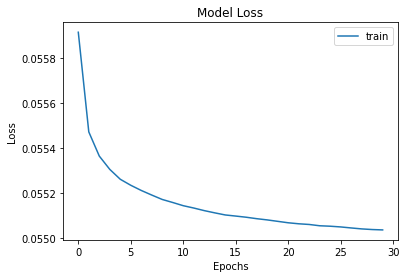

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot loss over epochs
my_dpi = 96
pyplot.title('Model Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.show()
pyplot.savefig('Train2019_batch8_Epochs_Loss_Updated.png', dpi=my_dpi * 10, bbox_inches='tight')

In [ ]:
# Make Predictions on Train
# Create empty table with 41 fields
train_predict = model.predict(train_X)
train_predict_dataset_like = np.zeros(shape=(len(train_predict), 41))

# Predicted values fill table
train_predict_dataset_like[:,0] = train_predict[:,0]

# Inverse transform and then select the right field
train_predict = scaler.inverse_transform(train_predict_dataset_like)[:,0]

print('Train Mean Absolute Error:', mean_absolute_error(train_y[:], train_predict[:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y[:], train_predict[:])))

Train Mean Absolute Error: 14.527630909053016
Train Root Mean Squared Error: 17.37103300923245


In [ ]:
# Make Predictions on Test
test_predict = model.predict(test_X)
test_predict_dataset_like = np.zeros(shape=(len(test_predict), 41))

# Invert predictions
test_predict_dataset_like[:,0] = test_predict[:,0]

# Inverse transform and then select the right field
test_predict = scaler.inverse_transform(test_predict_dataset_like)[:,0]

print('Test Mean Absolute Error:', mean_absolute_error(test_y[:], test_predict[:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y[:], test_predict[:])))

Test Mean Absolute Error: 48.90412796388756
Test Root Mean Squared Error: 116.52741560434524


In [ ]:
# Make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

In [ ]:
# Invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [ ]:
# Predicted maximum, average and minimum metric tonnage
print("Predicted Max Metric Tons")
print(np.amax(inv_yhat))
("\n")
print("Predicted Average Metric Tons")
print(np.average(inv_yhat))
("\n")
print("Predicted Minimum Metric Tons")
print(np.amin(inv_yhat))

Predicted Max Metric Tons
1621.6544
Predicted Average Metric Tons
-24.67689
Predicted Minimum Metric Tons
-2013.7032


In [ ]:
# Invert scaling for actual test data
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [ ]:
# Maxmimum, average and minimum real metric tonnage
print("Maximum Metric Tons")
print(np.amax(inv_y))
("\n")
print("Average Metric Tons")
print(np.average(inv_y))
("\n")
print("Minimum Metric Tons")
print(np.amin(inv_y))

Maximum Metric Tons
249.99
Average Metric Tons
21.535204
Minimum Metric Tons
0.0


In [ ]:
# Calculate RMSE
print('Mean Absolute Error (MAE): %3f' % sklearn.metrics.mean_absolute_error(inv_y, inv_yhat))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(inv_y, inv_yhat))

Mean Absolute Error (MAE): 53.372280
Mean Square Error (MSE): 15196.197266


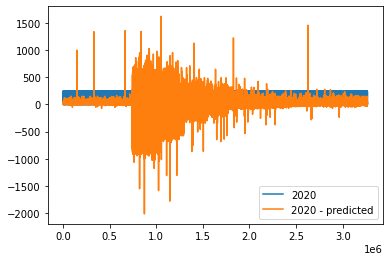

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot actual vs predicted metric tonnage
my_dpi = 96
pyplot.plot(inv_y, label = '2020')
pyplot.plot(inv_yhat, label = '2020 - predicted')
pyplot.legend()
pyplot.show()
pyplot.savefig('Train2019_batch8_Epochs_ActVersusPred_Updated.png', dpi=my_dpi * 10, bbox_inches='tight')